In [2]:
%matplotlib notebook

from Bio.PDB import PDBParser, NeighborSearch, Selection, Vector, vectors
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import math
from math import sin, cos
from mpl_toolkits.mplot3d import proj3d
import pandas as pd
import os

import matplotlib.animation as animation


import warnings
warnings.filterwarnings('ignore')

In [3]:
def angle(v1, v2,acute):
    # v1 is your first vector
    # v2 is your second vector
    angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
    if (acute == True):
        return angle * 57.2958
    else:
        return 2 * 57.2958 * np.pi - angle

def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix


def plotter_3d(contact_atom_coords,center_coord):
    
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(projection = '3d')
    ax.set_axis_off()
    
    ax.axes.set_xlim3d(left= -1, right= 1) 
    ax.axes.set_ylim3d(bottom= -1 , top= 1) 
    ax.axes.set_zlim3d(bottom= -1, top= 1) 
    
    ax.scatter(0,0,0, color = "tomato",s=150,marker = "P")
    
    # Plot H-BONDS AND THEIR COLORS ##############################################
    
    h_bond_dists = []

    for coord in contact_atom_coords:
        h_bond_dists.append('%.2f'%(math.dist(coord-center_coord,(0,0,0))))
    
    h_bond_dists = np.array(h_bond_dists, dtype=np.float)
    
    c = clr.Normalize(2.2,3.5)
    
    mapper = cm.ScalarMappable(norm=c, cmap=cm.cool_r)
    
    i = 0
    
    for coord in contact_atom_coords:
        
        x = coord[0]-center_coord[0]
        y = coord[1]-center_coord[1]
        z = coord[2]-center_coord[2]
        

        im1, = ax.plot3D([x, 0], [y, 0], [z, 0], 
                  color = clr.to_hex(mapper.to_rgba(h_bond_dists[i])),
                  linestyle = 'dashed')

        
        # Gives the option of writing the actual H-bond distances on the plot
        '''
        ax.text((coord[0]-center_coord[0])*0.5,
                (coord[1]-center_coord[1])*0.5,
                (coord[2]-center_coord[2])*0.5,
                str(h_bond_dists[i])+'Å')
        '''
        
        i = i+1
        
    
    # Let's draw an ideal tetrahedron to superimpose over our water coordination network:
    # (±1,0,−1/2‾√),(0,±1,1/2‾√) are the coordinates of the vertices of the tetrahedron given a center at the origin
    # We'll rotate one of our vectors to align with a reference vector - which in this case is one of the H-bonding interactions
    
    matrix = rotation_matrix_from_vectors(np.array([1,0,-(2**-0.5)]),np.array([x,y,z]))
    vec1_rot = matrix.dot(np.array([1,0,-(2**-0.5)]))
    vec2_rot = matrix.dot(np.array([-1,0,-(2**-0.5)]))
    vec3_rot = matrix.dot(np.array([0,1,(2**-0.5)]))
    vec4_rot = matrix.dot(np.array([0,-1,(2**-0.5)]))
    
    im8, = ax.plot3D([vec1_rot[0], 0], [vec1_rot[1], 0], [vec1_rot[2], 0],color = 'black')
    im9, = ax.plot3D([vec2_rot[0], 0], [vec2_rot[1], 0], [vec2_rot[2], 0],color = 'black')
    im10, = ax.plot3D([vec3_rot[0], 0], [vec3_rot[1], 0], [vec3_rot[2], 0],color = 'black')
    im11, = ax.plot3D([vec4_rot[0], 0], [vec4_rot[1], 0], [vec4_rot[2], 0],color = 'black')
    
    #create an image list that encompasses the lines that will be toggled on and off by the "t" key
    
    image_list = []
    
    image_list.append(im8)
    image_list.append(im9)
    image_list.append(im10)
    image_list.append(im11) 
    
    i = 0
    for image in image_list:
        image.set_visible(False)
        
    def toggle_images(event):
        'toggle the visible state of the two images'
        if event.key != 't':
            return
        
        i = 0
        
        for image in image_list:
            image.set_visible(not image.get_visible())
        plt.draw()

    plt.connect('key_press_event', toggle_images)
    
    plt.colorbar(mapper)
    
    #plt.savefig(input('plot name: '))
    plt.show()
    


In [4]:
#function that returns the angles between all the bonds connected to the water
def bond_angles(contact_atom_coords,center_coord,contact_atom_name,center_atom_name):
    
    bond_combinations = []
    bond_angles = []
    atom_combinations = []
    
    for combination in itertools.combinations(contact_atom_coords-center_coord,2):
        bond_combinations.append(combination)
    
    for combination in itertools.combinations(contact_atom_name,2):
        atom_combinations.append(combination)

    for combination in bond_combinations:
        bond_angles.append(180*angle(combination[0],combination[1],True)/np.pi)
    
    i = 0
    
    while(i<len(bond_angles)):
        print("the angle between: " + str(atom_combinations[i]) + ' is ' + str(bond_angles[i]))
        i = i +1
    

In [5]:
def process_pdb(filepath,target_atom_id,chain_id):
    
    parser = PDBParser()

    structure = parser.get_structure("yup", filepath) # select the file to import

    chain_list = Selection.unfold_entities(structure, "C")

    i = 0
    for chain in chain_list: # figure out the index of the target chain in the pdb
        if chain_id in str(chain):
            chain_index = i
            break
        i = i +1

    chain_atom_list = Selection.unfold_entities(chain_list[chain_index], "A") # creates a list of all atoms in target chain 

    atom_list = Selection.unfold_entities(chain_list, "A") # creates a list of all atoms in all chains
    
    chain_atom_ids = []
    for atom in chain_atom_list: 
        chain_atom_ids.append(atom.get_full_id()[4][0]+"_"+str(atom.get_full_id()[3][1]))
    
    target_atom = chain_atom_list[chain_atom_ids.index(str(target_atom_id))]
    center_coord = target_atom.coord

    distance_list = []
    vector_list = []

    residue_coords = {}
    residue_atoms = []

    cluster_atoms = []
    cluster_coords = []


    # Finds atoms within hydrogen bonding distance to the target atom
    contact_atoms = NeighborSearch(atom_list).search(center = center_coord,radius = 3.35,level = "A")

    # This statement removes the target water itself from being considered a "contact" atom
    contact_atoms = [item for item in contact_atoms if item.coord[0] != center_coord[0] and 
                     item.coord[1] != center_coord[1] and 
                    item.coord[2] != center_coord[2]]   
    
    contact_atoms = [item for item in contact_atoms if item.get_occupancy() != 0]

    # for every atom, in contact_atoms, switch to B conformation 
    
    for atom in contact_atoms:
        
        atom_conformations = []
        
        if atom.is_disordered() != 0:
            for entry in atom:
                print(entry.get_altloc() + ' this a possible conformation of this atom ' )
                atom_conformations.append(entry.get_altloc())
            if 'B' in atom_conformations:
                atom.disordered_select('B')  
            print(atom.get_altloc() + " is the conformation we switched to")

    contact_atom_coordinates = []
    contact_atom_name = []
    center_atom_name = atom.name

    if len(contact_atoms) > 1:

        for contact in contact_atoms:
            
            if contact.element == 'O' or contact.element == 'N':

                    contact_atom_coordinates.append(contact.coord)
                    contact_atom_name.append(contact.name+
                                            ' of residue '+contact.get_parent().get_resname()+
                                            " "+str(contact.get_full_id()[3][1]))

            '''
            if (contact.get_parent().get_resname() != "OEZ"):

                    
            if (contact.get_parent().get_resname() == "OEZ"):

                if contact.element == 'O' or contact.element == 'N':

                    contact_atom_coordinates.append(contact.coord)
                    contact_atom_name.append(contact.name+
                                            ' of residue '+contact.get_parent().get_resname()+
                                            " "+str(contact.get_full_id()[3][1]))
            '''
                    
    return contact_atom_coordinates,center_coord, contact_atom_name,center_atom_name


In [6]:
def write_H_bonds(contact_atom_names,center_atom_name,contact_atom_coordinates,center_coord):
    
    h_bond_dists = []
    
    dictionary = {}
    
    for coord in contact_atom_coordinates:
        h_bond_dists.append('%.2f'%(math.dist(coord-center_coord,(0,0,0))))
    
    i = 0
    for name in contact_atom_names:
        dictionary[name] = float(h_bond_dists[i])
        i = i+1
    
    return dictionary

    

In [7]:
def construct_dataframe(dict_list,filenames):
    
    rows = []
    
    for dictionary in dict_list:
        rows = rows + list(dictionary.keys())
    
    rows = list(set(rows))
    
    df = pd.DataFrame(rows)
    
    i = 0
    
    for dictionary in dict_list:
        file_distances = []
        for label in rows:
            if label in dictionary.keys():
                file_distances.append(dictionary[label])
            else:
                file_distances.append(np.nan)

        df[filenames[i]] = file_distances
        i = i+1
 
    return df
    

# Using the Script

The user must provide a list of waters to observe, the directory containing the timepoint PDB files, and an output directory for the resulting excel files to be saved to.


0F.pdb


<IPython.core.display.Javascript object>


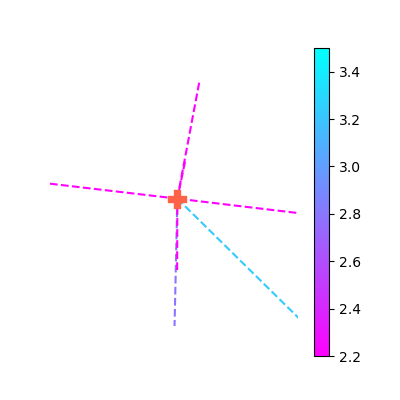

1F.pdb


<IPython.core.display.Javascript object>


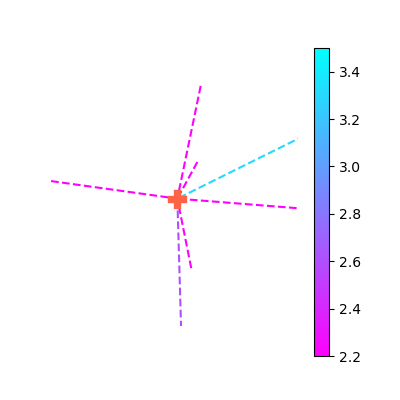

1F050.pdb


<IPython.core.display.Javascript object>


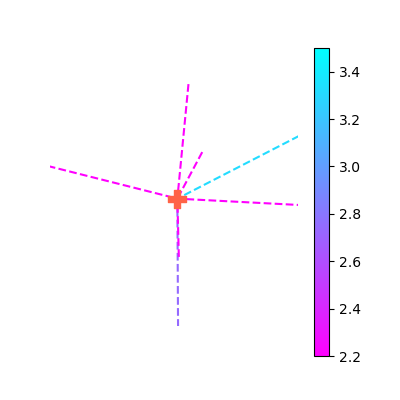

1F150.pdb
B this a possible conformation of this atom 
B is the conformation we switched to
A this a possible conformation of this atom 
A is the conformation we switched to
B this a possible conformation of this atom 
B is the conformation we switched to
A this a possible conformation of this atom 
A is the conformation we switched to
A this a possible conformation of this atom 
B this a possible conformation of this atom 
B is the conformation we switched to
A this a possible conformation of this atom 
B this a possible conformation of this atom 
B is the conformation we switched to
A this a possible conformation of this atom 
B this a possible conformation of this atom 
B is the conformation we switched to
A this a possible conformation of this atom 
A is the conformation we switched to
B this a possible conformation of this atom 
B is the conformation we switched to
A this a possible conformation of this atom 
A is the conformation we switched to
B this a possible conformation of t

<IPython.core.display.Javascript object>


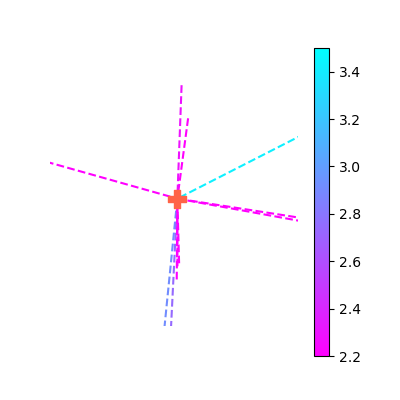

1F250.pdb
B this a possible conformation of this atom 
B is the conformation we switched to
A this a possible conformation of this atom 
A is the conformation we switched to
A this a possible conformation of this atom 
B this a possible conformation of this atom 
B is the conformation we switched to
B this a possible conformation of this atom 
B is the conformation we switched to
A this a possible conformation of this atom 
B this a possible conformation of this atom 
B is the conformation we switched to
A this a possible conformation of this atom 
B this a possible conformation of this atom 
B is the conformation we switched to
A this a possible conformation of this atom 
B this a possible conformation of this atom 
B is the conformation we switched to
A this a possible conformation of this atom 
A is the conformation we switched to
A this a possible conformation of this atom 
A is the conformation we switched to
B this a possible conformation of this atom 
B is the conformation we sw

<IPython.core.display.Javascript object>


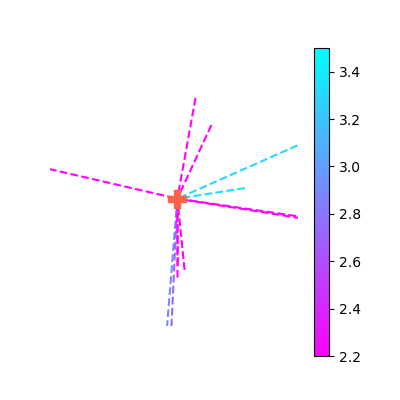

1F400.pdb
B this a possible conformation of this atom 
B is the conformation we switched to
A this a possible conformation of this atom 
A is the conformation we switched to
A this a possible conformation of this atom 
B this a possible conformation of this atom 
B is the conformation we switched to
B this a possible conformation of this atom 
B is the conformation we switched to
A this a possible conformation of this atom 
A is the conformation we switched to
A this a possible conformation of this atom 
B this a possible conformation of this atom 
B is the conformation we switched to
A this a possible conformation of this atom 
B this a possible conformation of this atom 
B is the conformation we switched to
A this a possible conformation of this atom 
B this a possible conformation of this atom 
B is the conformation we switched to
A this a possible conformation of this atom 
A is the conformation we switched to
B this a possible conformation of this atom 
B is the conformation we sw

<IPython.core.display.Javascript object>


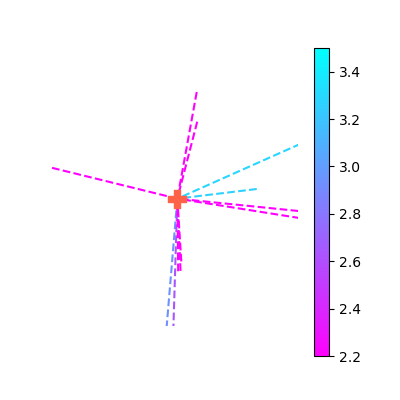

2F.pdb
B this a possible conformation of this atom 
B is the conformation we switched to
A this a possible conformation of this atom 
A is the conformation we switched to
A this a possible conformation of this atom 
A is the conformation we switched to
B this a possible conformation of this atom 
B is the conformation we switched to
A this a possible conformation of this atom 
B this a possible conformation of this atom 
B is the conformation we switched to
A this a possible conformation of this atom 
B this a possible conformation of this atom 
B is the conformation we switched to
A this a possible conformation of this atom 
B this a possible conformation of this atom 
B is the conformation we switched to
A this a possible conformation of this atom 
A is the conformation we switched to
B this a possible conformation of this atom 
B is the conformation we switched to
A this a possible conformation of this atom 
A is the conformation we switched to
B this a possible conformation of this

<IPython.core.display.Javascript object>


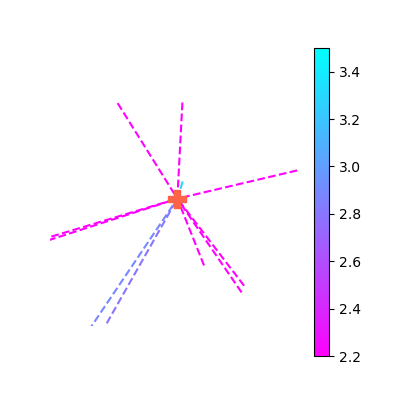

In [10]:
filenames = []
target_atom_list = ["MN1_601"]
chain_id = "A"

for target_atom in target_atom_list:
    
    dict_list = []
    
    target_atom_name = target_atom

    directory_in_str = '/Users/albertqiang/Desktop/Yano Lab Work/PDBs' #replace this with the directory containing your pdb files

    directory = os.fsencode(directory_in_str)

    for file in sorted(os.listdir(directory)):
        filename = os.fsdecode(file)
        if filename.endswith(".pdb"):
            
            print(filename)
            
            filepath = directory_in_str+'/'+filename
            
            contact_atom_coordinates, center_coord, contact_atom_name, center_atom_name = process_pdb(filepath,target_atom_name,chain_id)


            h_bonds = write_H_bonds(contact_atom_name,center_atom_name,contact_atom_coordinates,center_coord)
            
            plotter_3d(contact_atom_coordinates,center_coord)
            
            
            dict_list.append(h_bonds)
            filenames.append(filename)


    df = construct_dataframe(dict_list,filenames)
    df
    #df.to_excel('/Users/albertqiang/Desktop/Yano Lab Work/water_'+str(water_name)+'bond_network.xlsx') # replace this with your output directory

In [11]:
df

,0,0F.pdb,1F.pdb,1F050.pdb,1F150.pdb,1F250.pdb,1F400.pdb,2F.pdb
0,O2 of residue OEZ 601,3.23,NaN,NaN,NaN,NaN,NaN,NaN
1,O1 of residue OEZ 601,1.99,1.99,1.94,1.96,1.92,1.90,1.94
2,O3 of residue OEZ 601,1.94,1.94,1.84,1.88,1.93,1.93,1.89
3,OD1 of residue ASP 342,NaN,3.30,3.32,3.42,3.31,3.29,3.28
4,O3 of residue OEC 601,NaN,NaN,NaN,2.13,2.05,1.99,1.97
5,OE2 of residue GLU 189,1.71,1.72,1.74,1.72,1.89,1.97,2.00
6,O5 of residue OEC 601,NaN,NaN,NaN,2.74,2.73,2.64,2.79
7,OE1 of residue GLU 189,NaN,NaN,NaN,NaN,3.32,3.27,NaN
8,NE2 of residue HIS 332,2.11,2.10,2.07,2.12,2.19,2.15,2.21
9,O6 of residue OEZ 601,NaN,NaN,NaN,1.81,1.83,1.80,1.81
